We'll write a simplifier a la Luckasz

In [251]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tqdm import tqdm


class Solver:
    def __init__(self, n_qubits=3, qlr=0.01, qepochs=200,verbose=0, g=1, J=0):

        """"solver with n**2 possible actions: n(n-1) CNOTS + n 1-qubit unitary"""
        self.n_qubits = n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.lower_bound_Eg = -2*self.n_qubits
        
        self.qlr = qlr
        self.qepochs=qepochs
        self.verbose=verbose


        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        
        self.final_params = []
        self.parametrized_unitary = [cirq.rz, cirq.rx, cirq.rz]
        
        self.observable=self.ising_obs(g=g, J=J)
        
    def ising_obs(self, g=1, J=0):
        # g \sum_i Z_i - J \sum_{i} X_i X_{i+1}
        observable = [float(g)*cirq.Z.on(q) for q in self.qubits] 
        for q in range(len(self.qubits)):
            observable.append(float(J)*cirq.X.on(self.qubits[q])*cirq.X.on(self.qubits[(q+1)%len(self.qubits)]))
        self.ground_energy = -g*np.sum(np.sqrt([1+(J/4*g)**2 - (np.cos(q)*(J/2*g)) for q in range(self.n_qubits)]))
        return observable
        
    def index_meaning(self,index):
        if index<self.number_of_cnots:
            print("cnot: ",self.indexed_cnots[str(index)])
            return
        else:
            print("1-qubit unitary on: ",(index-self.number_of_cnots)%self.n_qubits)
            return

    def append_to_circuit(self, ind, circuit, params):
        """
        appends to circuit the index of the gate;
        and if one_hot_gate it implies a rotation,
        appends to params a symbol
        """

        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            return circuit, params
        else:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(3),self.parametrized_unitary):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
            return circuit, params
        
    def give_circuit(self, lista,one_hot=False):
        circuit, symbols = [], []
        for k in lista:
            circuit, symbols = self.append_to_circuit(k,circuit,symbols)
        circuit = cirq.Circuit(circuit)
        return circuit, symbols

    def dressed_cnot(self,q1,q2):
        u1 = self.number_of_cnots + q1
        u2 = self.number_of_cnots + q2
        cnot = self.cnots_index[str([q1,q2])]
        u3 = self.number_of_cnots + q1
        u4 = self.number_of_cnots + q2
        return [u1,u2,cnot,u3,u4]
    
    def dressed_ansatz(self, layers=1):
        c=[]
        for layer in range(layers):
            qubits = list(range(self.n_qubits))
            qdeph = qubits[layers:]
            for q in qubits[:layers]:
                qdeph.append(q)
            for ind1, ind2 in zip(qubits,qdeph):
                for k in self.dressed_cnot(ind1,ind2):
                    c.append(k)
        return c


    def TFQ_model(self, symbols):
        circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
        output = tfq.layers.Expectation()(
                circuit_input,
                symbol_names=symbols,
                operators=tfq.convert_to_tensor([self.observable]),
                initializer=tf.keras.initializers.RandomNormal()) #we may change this!!!
        model = tf.keras.Model(inputs=circuit_input, outputs=output)
        adam = tf.keras.optimizers.Adam(learning_rate=self.qlr)
        model.compile(optimizer=adam, loss='mse')
        return model


    def run_circuit(self, gates_index, sim_q_state=False):
        """
        takes as input vector with actions described as integer
        and outputsthe energy of that circuit (w.r.t self.observable)
        """
        ### create a vector with the gates on the corresponding qubit(s)
        circuit, symbols = self.give_circuit(gates_index)
        
        ### this is because each qubit should be "activated" in TFQ to do the optimization (if the observable has support on this qubit as well and you don't add I then error)
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))

        tfqcircuit = tfq.convert_to_tensor([circuit])
        if len(symbols) == 0:
            expval = tfq.layers.Expectation()(
                                            tfqcircuit,
                                            operators=tfq.convert_to_tensor([self.observable]))
            energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))
            self.final_params = []

        else:
            model = self.TFQ_model(symbols)
            qoutput = tf.ones((1, 1))*self.lower_bound_Eg
            model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=self.qepochs, verbose=self.verbose)
            energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
            self.final_params = [np.squeeze(k.numpy()) for k in model.trainable_variables]

        #if sim_q_state:
            #simulator = cirq.Simulator()
            #result = simulator.simulate(circuit, qubit_order=self.qubits)
            #probs = np.abs(result.final_state)**2
            #return energy, probs
        return energy

In [252]:
en=[]
gri = np.arange(.01,1,.1).astype(np.float32)
en = np.zeros((len(gri), len(gri)))
solved = np.zeros((len(gri), len(gri)))
for i1,J in tqdm(enumerate(gri)):
    for i2,g in enumerate(gri):
        sol = Solver(g=g, J=J)
        en[i1,i2] = sol.ground_energy
        solved[i1,i2] = sol.run_circuit(sol.dressed_ansatz(layers=1))

10it [05:15, 31.55s/it]


In [254]:
solved-en

array([[-4.06405680e-03, -2.51481765e-04, -1.29571051e-04,
        -4.25265157e-04, -6.34726999e-04,  3.20105740e-03,
         3.75256335e-03,  6.48052927e-03, -1.82733967e-03,
        -2.05014248e-03],
       [-8.94949816e-02, -4.52347708e-02, -2.41775373e-02,
        -2.13116794e-02, -2.01920982e-02, -2.00868947e-02,
        -2.23479628e-02, -2.63926032e-02, -2.81568246e-02,
        -3.33539951e-02],
       [-1.94862545e-01, -1.09504190e-01, -9.48205931e-02,
        -7.60280931e-02, -5.20330192e-02, -5.53492221e-02,
        -6.30053720e-02, -5.72030910e-02, -7.27138445e-02,
        -6.91545926e-02],
       [-2.79689468e-01, -1.88603338e-01, -1.68265951e-01,
        -1.36956200e-01, -1.16686586e-01, -1.22326609e-01,
        -1.14502673e-01, -1.00197341e-01, -1.06803322e-01,
        -1.32754892e-01],
       [-3.87640400e-01, -3.18561733e-01, -2.48761152e-01,
        -1.15276179e-01, -1.98618099e-01, -1.91751478e-01,
        -1.59227096e-01, -1.60657165e-01, -1.88526355e-01,
        -1.

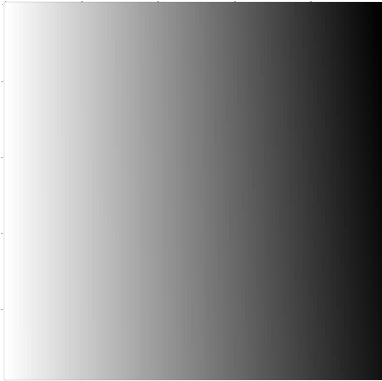

In [247]:
plt.figure(figsize=(50,50), dpi=10)
ax = plt.subplot2grid((1,1),(0,0))
ax.matshow(en,cmap=plt.get_cmap('gray'))

In [257]:
en=[]
gri = np.arange(.01,1,.1).astype(np.float32)
en = np.zeros((len(gri), len(gri)))
solved = np.zeros((len(gri), len(gri)))
for i1,J in tqdm(enumerate(gri)):
    for i2,g in enumerate(gri):
        sol = Solver(g=g, J=J,qepochs=1000, qlr=0.005)
        en[i1,i2] = sol.ground_energy
        solved[i1,i2] = sol.run_circuit(sol.dressed_ansatz(layers=2))

10it [58:35, 351.59s/it]


In [259]:
solved - en

array([[-4.64124210e-03, -6.84569114e-04, -4.71046061e-04,
        -5.06327474e-04, -6.49628160e-04, -8.73516120e-04,
        -1.16100515e-03, -1.51746038e-03, -1.92771390e-03,
        -2.39751835e-03],
       [-1.00653552e-01, -5.14212561e-02, -3.45424870e-02,
        -2.73701935e-02, -2.44044777e-02, -2.38213641e-02,
        -2.48122573e-02, -2.70246508e-02, -3.02179532e-02,
        -3.43055237e-02],
       [-2.00353623e-01, -1.33915451e-01, -1.00027059e-01,
        -8.17402446e-02, -7.19769718e-02, -6.74682769e-02,
        -6.66996679e-02, -6.86540970e-02, -7.28061125e-02,
        -7.89118729e-02],
       [-3.00241239e-01, -2.25500581e-01, -1.79991674e-01,
        -1.52050480e-01, -1.35257963e-01, -1.26070854e-01,
        -1.22390990e-01, -1.23053338e-01, -1.27106810e-01,
        -1.34144634e-01],
       [-4.00189114e-01, -3.20697308e-01, -2.67339145e-01,
        -2.31863818e-01, -2.08954498e-01, -1.95219157e-01,
        -1.88513957e-01, -1.87402961e-01, -1.90807783e-01,
        -1.